# Diccionario de los datos

| Variable | Descripción |
|----------|-------------|
| fecha_dato | este es el id, los datos están separados por este dato |



# Importación de los datos para su análisis

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definición de rutas del proyecto
raiz = os.path.dirname(os.getcwd())
db = os.path.join(raiz, "database.db")
train_data = 'santander_train_data'

In [3]:
conn = sqlite3.connect("../database.db")
query = f"SELECT * FROM {train_data} "
df = pd.read_sql_query(query, conn)

print(f"Trayendo la tabla {train_data} con dimensiones de: {df.shape}")

Trayendo la tabla santander_train_data con dimensiones de: (1163282, 70)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163282 entries, 0 to 1163281
Data columns (total 70 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   ncodpers                           1163282 non-null  int64  
 1   fecha_dato                         1163282 non-null  object 
 2   ind_empleado                       1163282 non-null  object 
 3   pais_residencia                    1163282 non-null  object 
 4   sexo                               1163270 non-null  object 
 5   age                                1163282 non-null  object 
 6   fecha_alta                         1163282 non-null  object 
 7   ind_nuevo                          1163282 non-null  float64
 8   antiguedad                         1163282 non-null  object 
 9   indrel_1mes                        1163282 non-null  object 
 10  tiprel_1mes                        1163282 non-null  object 
 11  indresi                 

## Limpieza de datos y formateo correcto de variables

### Datos numéricos
- Primero vamos a verificar qué variables tienen nulos
- También tenemos que convertir los datos que deberían ser numéricos pero están como 'object'.
- Y por último vamos a cambiar el formato de las fechas

In [5]:
nulos = df.isnull().sum()
nulos = nulos[nulos > 0]

print(nulos)

sexo                  12
conyuemp         1163030
canal_entrada         29
cod_prov            6480
nomprov             6480
renta             256383
segmento              29
dtype: int64


In [6]:
df.describe()

,ncodpers,ind_nuevo,cod_prov,ind_actividad_cliente,renta,target_ind_fond_fin_ult1_acquired,target_ind_ctpp_fin_ult1_acquired,target_ind_dela_fin_ult1_acquired,target_ind_hip_fin_ult1_acquired,target_ind_reca_fin_ult1_acquired,...,ind_cco_fin_ult1_prev,ind_viv_fin_ult1_prev,ind_nom_pens_ult1_prev,ind_nomina_ult1_prev,ind_recibo_ult1_prev,ind_pres_fin_ult1_prev,ind_cno_fin_ult1_prev,ind_cder_fin_ult1_prev,ind_plan_fin_ult1_prev,target_any_new_product
count,1.163282e+06,1.163282e+06,1.156802e+06,1163282.0,9.068990e+05,1.163282e+06,1.163282e+06,1.163282e+06,1.163282e+06,1.163282e+06,...,1.163282e+06,1.163282e+06,1.163282e+06,1.163282e+06,1.163282e+06,1.163282e+06,1.163282e+06,1.163282e+06,1.163282e+06,1.163282e+06
mean,8.130370e+05,5.016153e-02,2.695418e+01,1.0,1.403573e+05,1.908394e-04,3.421354e-04,3.137674e-04,8.596368e-06,9.791263e-04,...,7.440002e-01,5.922897e-03,1.299556e-01,1.189686e-01,2.832366e-01,4.213940e-03,1.781580e-01,7.435858e-04,1.890341e-02,6.230304e-02
std,4.671182e+05,2.182782e-01,1.223142e+01,0.0,2.450904e+05,1.381315e-02,1.849375e-02,1.771071e-02,2.931945e-03,3.127568e-02,...,4.364219e-01,7.673214e-02,3.362547e-01,3.237517e-01,4.505705e-01,6.477797e-02,3.826459e-01,2.725864e-02,1.361840e-01,2.417052e-01
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,3.731790e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.886130e+05,0.000000e+00,1.900000e+01,1.0,7.304952e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.600205e+05,0.000000e+00,2.800000e+01,1.0,1.082551e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.245705e+06,0.000000e+00,3.300000e+01,1.0,1.645236e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.548142e+06,1.000000e+00,5.200000e+01,1.0,2.889440e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
df.describe(include=object)

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,segmento
count,1163282,1163282,1163282,1163270,1163282,1163282,1163282,1163282,1163282,1163282,1163282,252,1163253,1163282,1156802,1163253
unique,3,5,105,2,115,6628,258,4,3,2,2,2,152,2,52,3
top,2016-05-28 00:00:00,N,ES,V,21,2014-07-28,8,1.0,A,S,N,N,KAT,N,MADRID,02 - PARTICULARES
freq,390565,1162036,1156800,663992,41682,4630,23215,891935,1052672,1156799,1112653,249,331572,1160353,449674,770663


In [8]:
df['age'] = pd.to_numeric(df['age'], errors="coerce")
df['age'].unique()

array([ 56,  63,  62,  60,  49,  50,  57,  58,  51,  53,  47,  48,  54,
        55,  52,  61,  71,  46,  66,  59,  65,  67,  72,  68,  69,  80,
        84,  74,  88,  76,  64,  73,  82,  81,  70,  45,  44,  78,  77,
        89,  75,  41,  36,  37,  90,  83,  95,  42,  86,  87,  92,  93,
        94,  79, 100, 101,  39,  40,  43,  85,  91,  30,  31,  96,  97,
        34, 104,  99,  28, 106, 103,  38,  98, 107, 102,  26, 111, 108,
       110, 105,  35,  33, 109,  27, 113, 116, 112,  16, 117,  17,  22,
        25,  23,  24,  20,  18,  29,  32,  19,  21,  15,   2,  14, 114,
        13,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3])

In [9]:
df['antiguedad'] = pd.to_numeric(df['antiguedad'], errors='coerce')
df['antiguedad'].replace(-999999, np.nan, inplace=True)
df.dropna(subset=['antiguedad'], inplace=True)
df['antiguedad'].unique()

array([253., 254., 255., 256., 235., 237., 252., 238., 239., 207., 208.,
       209., 234., 236., 248., 249., 250., 231., 232., 233., 251., 214.,
       215., 216., 198., 199., 200., 105., 106., 107., 141., 142., 143.,
       226., 227., 228., 145., 146., 147., 194., 195., 196., 210., 211.,
       206., 203., 204., 205., 246., 247., 243., 244., 245.,  61.,  62.,
        63., 217., 218., 137., 138., 139.,  29.,  30.,  31., 118., 119.,
       120., 229., 230., 129., 130., 131., 187., 188., 189.,  76.,  77.,
        78.,   6.,   7.,   8., 240., 241., 152., 153., 154., 219., 159.,
       160., 161., 144.,  34.,  35.,  36., 148., 115., 116., 117., 132.,
       133., 220., 221., 222., 213., 177., 178., 180.,  11.,  12.,  13.,
       149., 150., 151.,  26.,  27.,  28., 242.,  69.,  70.,  71., 223.,
       162., 163.,   5., 168., 169., 170.,  89.,  90.,  91.,  88., 192.,
       193., 201., 202., 224., 225.,  41.,  42.,  43., 182., 183., 184.,
       121., 122.,  55.,  56.,  57., 179., 181., 17

In [10]:
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'], errors='coerce')
df['fecha_alta'] = pd.to_datetime(df['fecha_alta'], errors='coerce')

In [11]:
df['indrel_1mes'].unique()

array(['1.0', '1', '3.0', '3'], dtype=object)

In [12]:
df['indrel_1mes'] = pd.to_numeric(df['indrel_1mes'], errors='coerce')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1163276 entries, 0 to 1163281
Data columns (total 70 columns):
 #   Column                             Non-Null Count    Dtype         
---  ------                             --------------    -----         
 0   ncodpers                           1163276 non-null  int64         
 1   fecha_dato                         1163276 non-null  datetime64[ns]
 2   ind_empleado                       1163276 non-null  object        
 3   pais_residencia                    1163276 non-null  object        
 4   sexo                               1163264 non-null  object        
 5   age                                1163276 non-null  int64         
 6   fecha_alta                         1163276 non-null  datetime64[ns]
 7   ind_nuevo                          1163276 non-null  float64       
 8   antiguedad                         1163276 non-null  float64       
 9   indrel_1mes                        1163276 non-null  float64       
 10  tiprel_1mes

In [14]:
df.describe()

,ncodpers,fecha_dato,age,fecha_alta,ind_nuevo,antiguedad,indrel_1mes,cod_prov,ind_actividad_cliente,renta,...,ind_cco_fin_ult1_prev,ind_viv_fin_ult1_prev,ind_nom_pens_ult1_prev,ind_nomina_ult1_prev,ind_recibo_ult1_prev,ind_pres_fin_ult1_prev,ind_cno_fin_ult1_prev,ind_cder_fin_ult1_prev,ind_plan_fin_ult1_prev,target_any_new_product
count,1.163276e+06,1163276,1.163276e+06,1163276,1.163276e+06,1.163276e+06,1.163276e+06,1.156796e+06,1163276.0,9.068960e+05,...,1.163276e+06,1.163276e+06,1.163276e+06,1.163276e+06,1.163276e+06,1.163276e+06,1.163276e+06,1.163276e+06,1.163276e+06,1.163276e+06
mean,8.130389e+05,2016-04-27 20:02:55.828952064,4.259334e+01,2008-09-21 09:33:09.885118208,5.016178e-02,8.885670e+01,1.000012e+00,2.695418e+01,1.0,1.403571e+05,...,7.440014e-01,5.922928e-03,1.299511e-01,1.189640e-01,2.832337e-01,4.213961e-03,1.781546e-01,7.435897e-04,1.889835e-02,6.230250e-02
min,1.588900e+04,2016-03-28 00:00:00,2.000000e+00,1995-01-16 00:00:00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.0,3.731790e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.886130e+05,2016-03-28 00:00:00,2.900000e+01,2003-03-07 00:00:00,0.000000e+00,2.400000e+01,1.000000e+00,1.900000e+01,1.0,7.304952e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.600215e+05,2016-04-28 00:00:00,4.200000e+01,2010-04-21 00:00:00,0.000000e+00,6.600000e+01,1.000000e+00,2.800000e+01,1.0,1.082540e+05,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.245706e+06,2016-05-28 00:00:00,5.200000e+01,2014-04-02 00:00:00,0.000000e+00,1.540000e+02,1.000000e+00,3.300000e+01,1.0,1.645228e+05,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.548142e+06,2016-05-28 00:00:00,1.170000e+02,2016-04-29 00:00:00,1.000000e+00,2.560000e+02,3.000000e+00,5.200000e+01,1.0,2.889440e+07,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,4.671181e+05,NaN,1.619098e+01,NaN,2.182788e-01,7.111927e+01,4.906101e-03,1.223145e+01,0.0,2.450908e+05,...,4.364212e-01,7.673234e-02,3.362498e-01,3.237463e-01,4.505691e-01,6.477814e-02,3.826430e-01,2.725871e-02,1.361662e-01,2.417043e-01


In [15]:
numerical_cols = [
    'age', 'antiguedad', 'renta', 'cod_prov', 'ind_nuevo', 'ind_actividad_cliente', 'indrel_1mes'
]

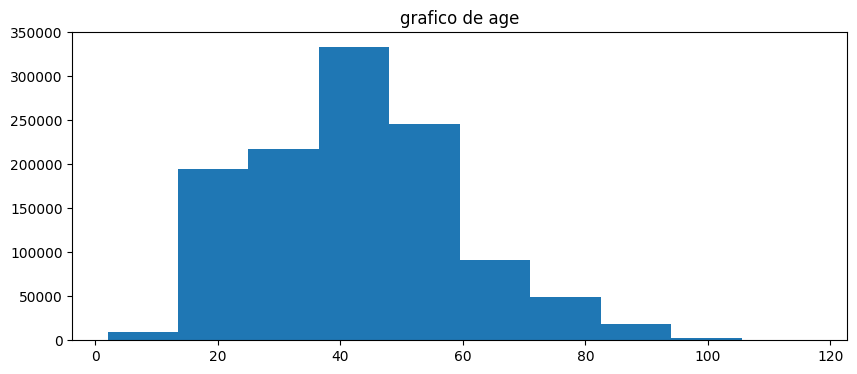

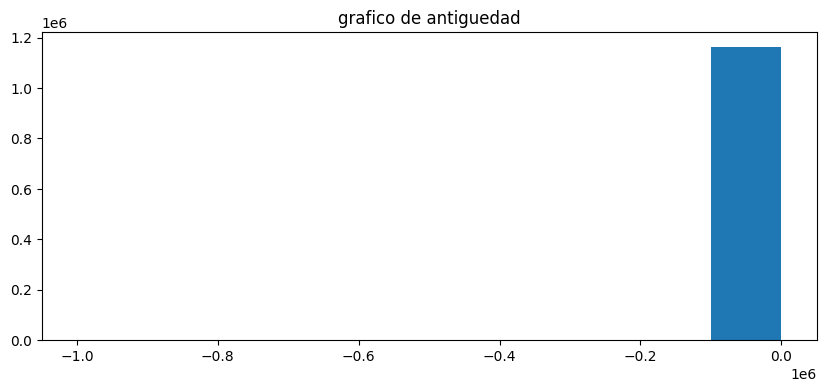

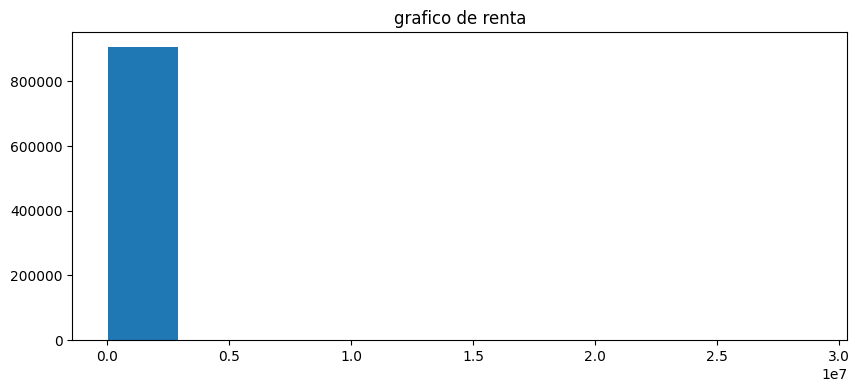

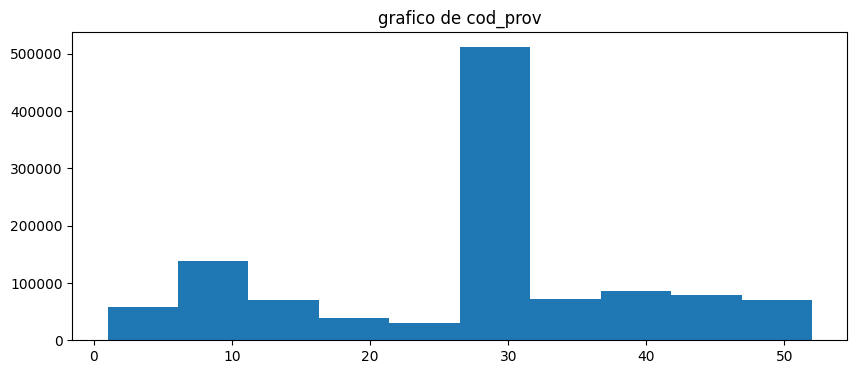

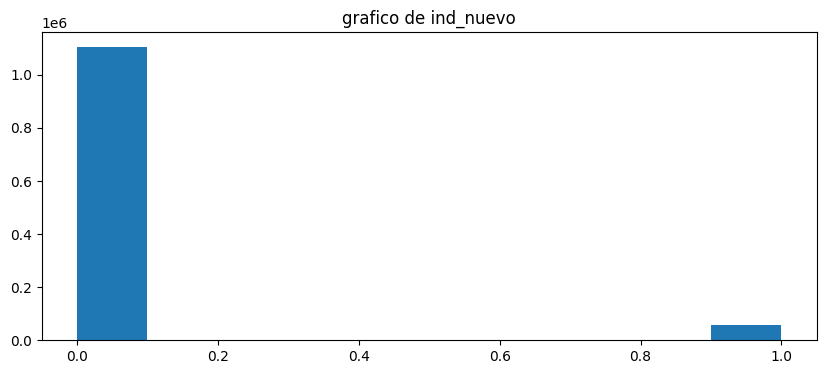

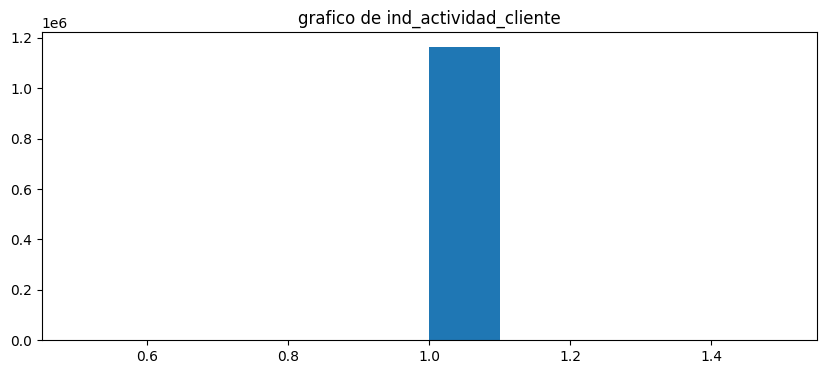

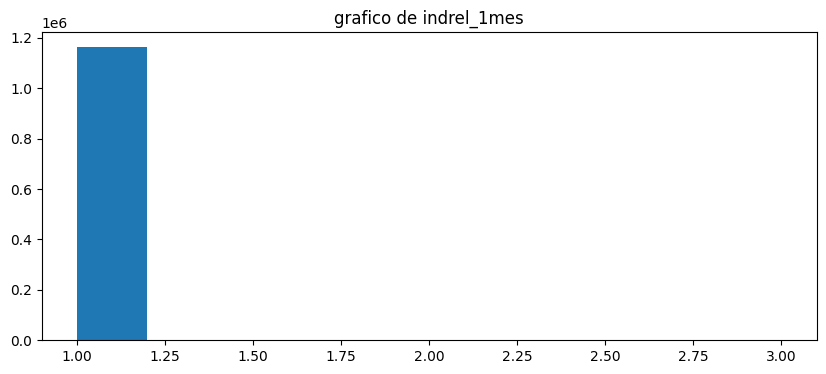

In [11]:
for col in numerical_cols:
    plt.figure(figsize=(10,4))
    plt.hist(df[col], bins=10, label=col)
    plt.title(f"grafico de {col}")
    plt.show()

#### Eliminar los outliers de las variables numéricas

- También pude aplicar lo siguiente:

```
df = df[df['renta'] < df['renta'].quantile(0.995)]
df = df[df['age'].between(18, 100)]
df = df[df['antiguedad'].between(0, 240)]
```


In [16]:
df_copia = df.copy()
for col in df_copia.select_dtypes(include=["int64", "float64"]).columns:
    cuartil_bajo = df[col].quantile(0.005)
    cuartil_alto = df[col].quantile(0.995)

    df_copia = df_copia[(df_copia[col] >= cuartil_bajo) & (df_copia[col] <= cuartil_alto)]

df_copia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 871619 entries, 5822 to 1081520
Data columns (total 70 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   ncodpers                           871619 non-null  int64         
 1   fecha_dato                         871619 non-null  datetime64[ns]
 2   ind_empleado                       871619 non-null  object        
 3   pais_residencia                    871619 non-null  object        
 4   sexo                               871613 non-null  object        
 5   age                                871619 non-null  int64         
 6   fecha_alta                         871619 non-null  datetime64[ns]
 7   ind_nuevo                          871619 non-null  float64       
 8   antiguedad                         871619 non-null  float64       
 9   indrel_1mes                        871619 non-null  float64       
 10  tiprel_1mes          

In [24]:
df_copia["ind_nuevo"].value_counts()

ind_nuevo
0.0    870834
1.0       785
Name: count, dtype: int64

In [21]:
df_copia["ind_actividad_cliente"].unique()

array([1.])

In [22]:
df_copia["indrel_1mes"].unique()

array([1.])

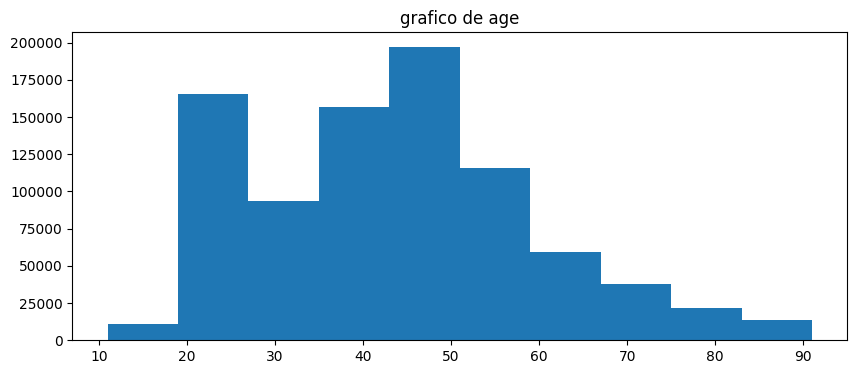

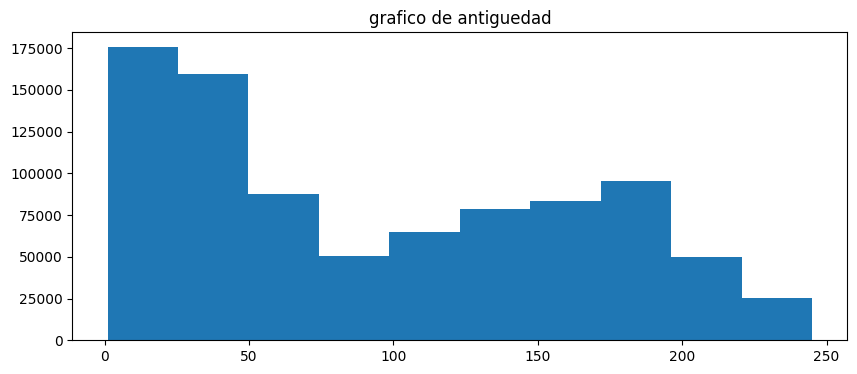

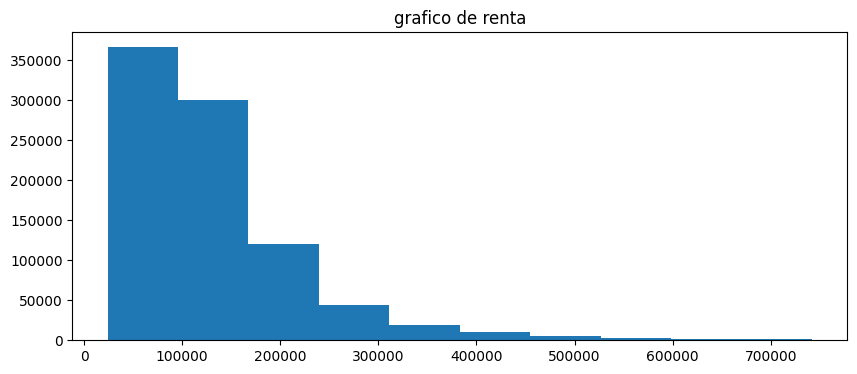

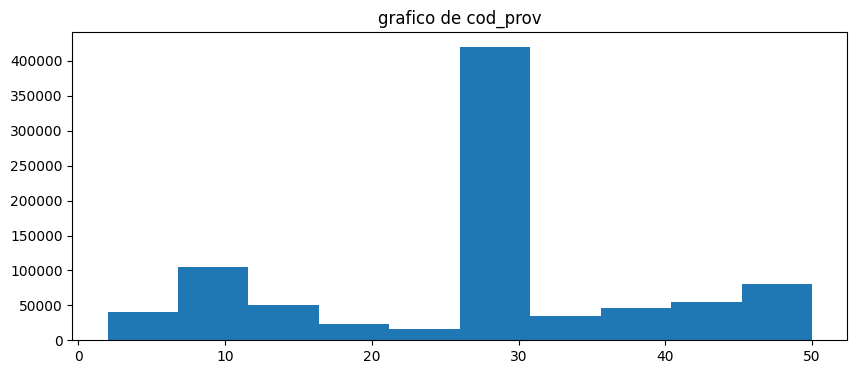

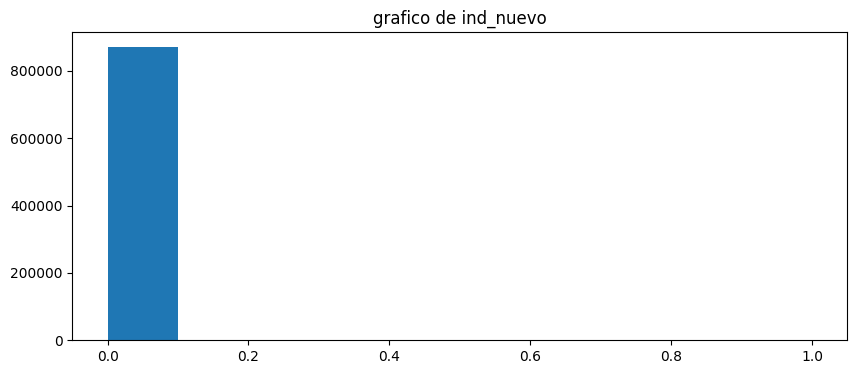

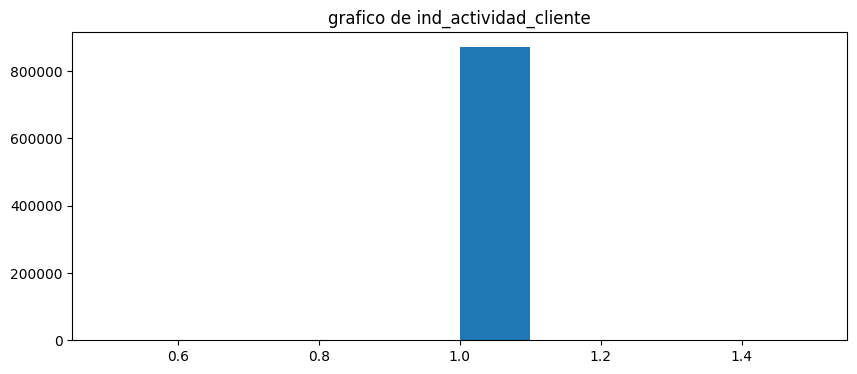

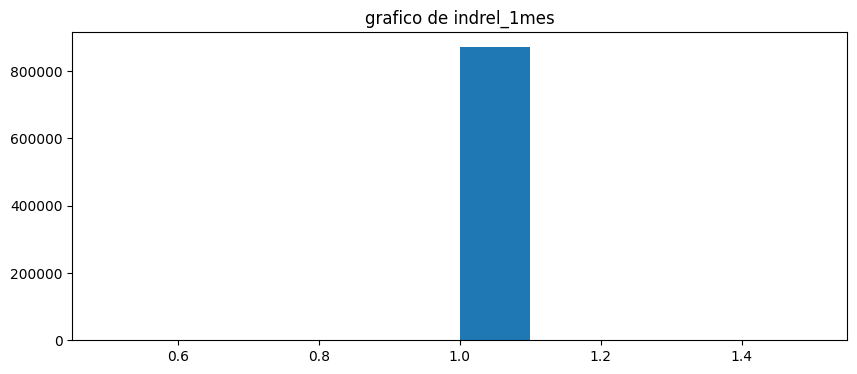

In [17]:
for col in numerical_cols:
    plt.figure(figsize=(10,4))
    plt.hist(df_copia[col], bins=10, label=col)
    plt.title(f"grafico de {col}")
    plt.show()

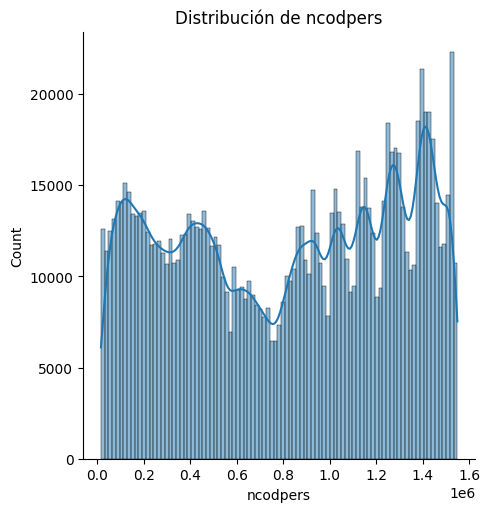

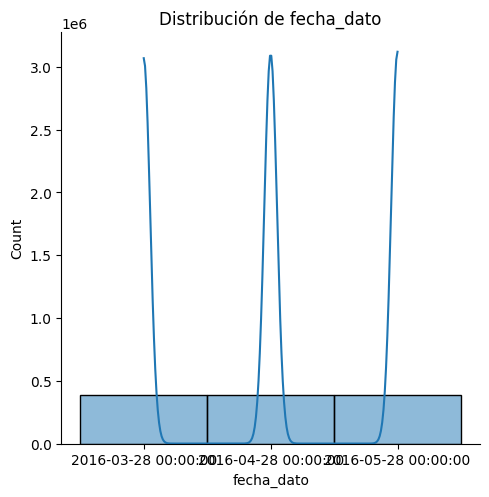

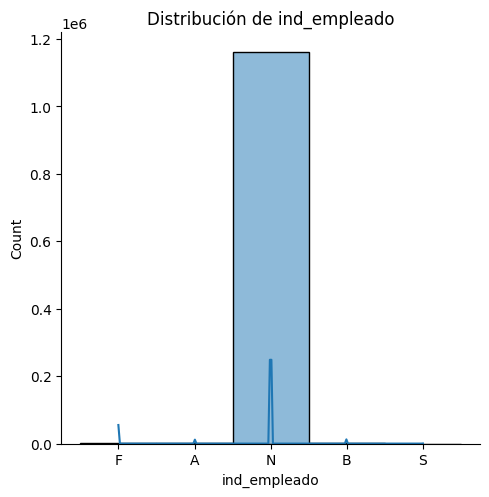

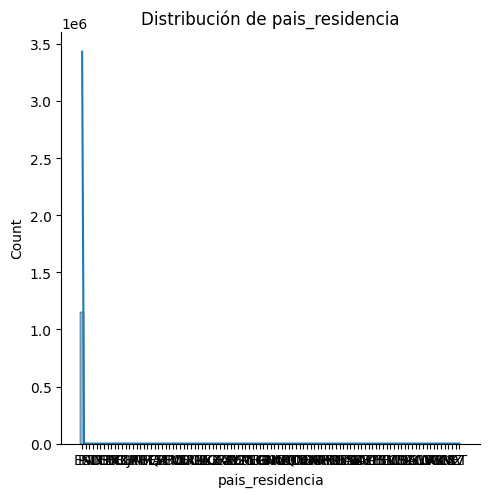

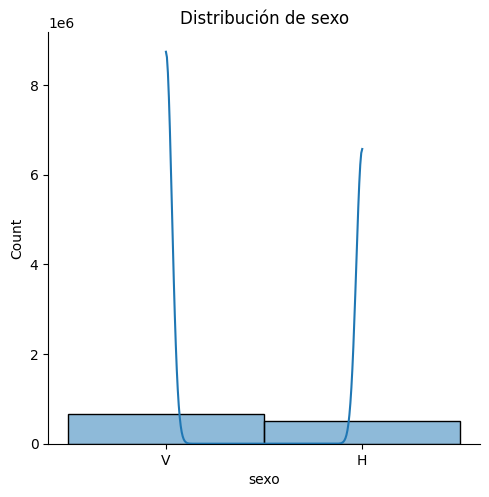

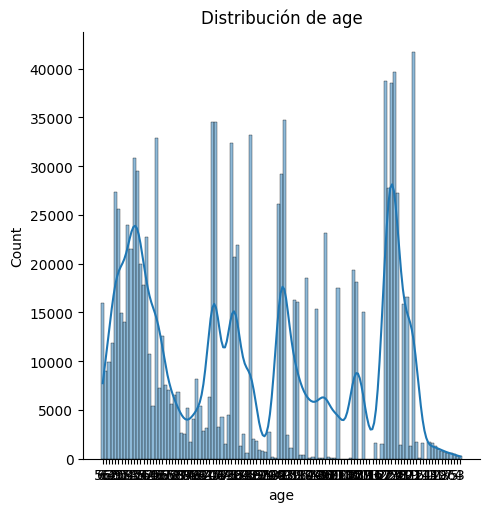

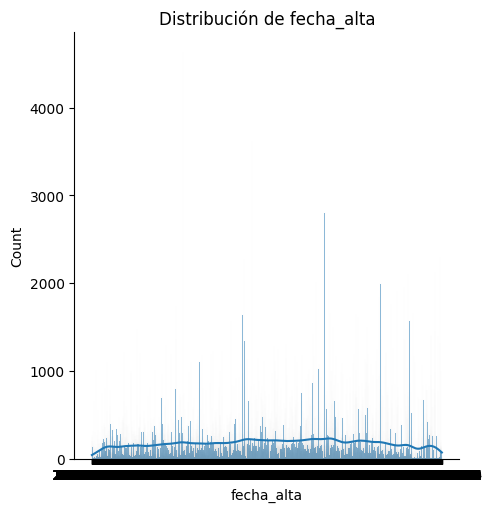

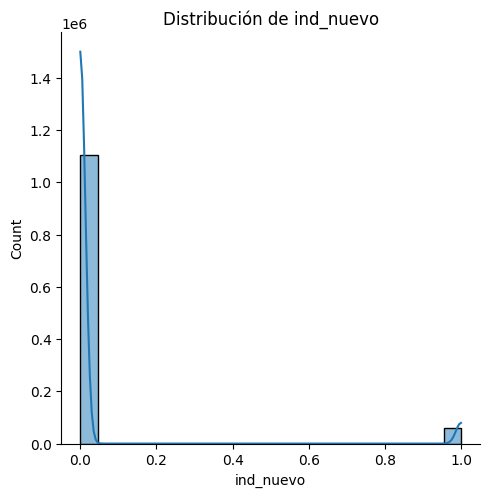

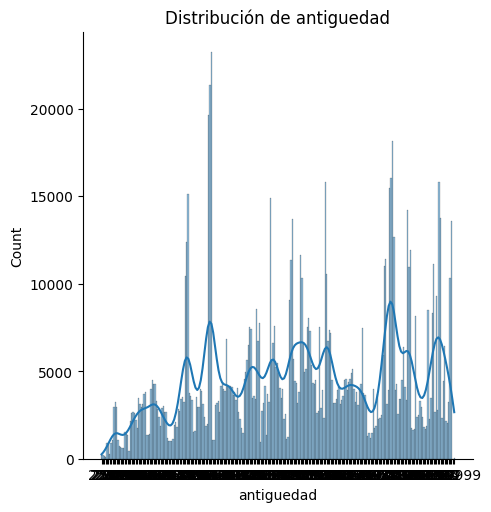

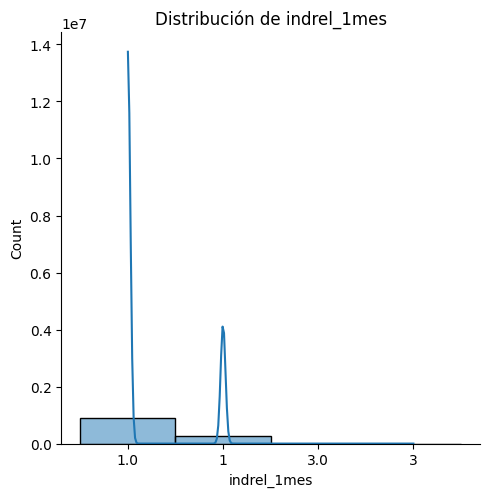

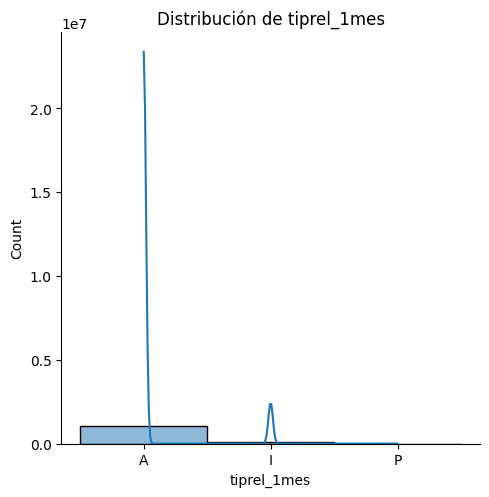

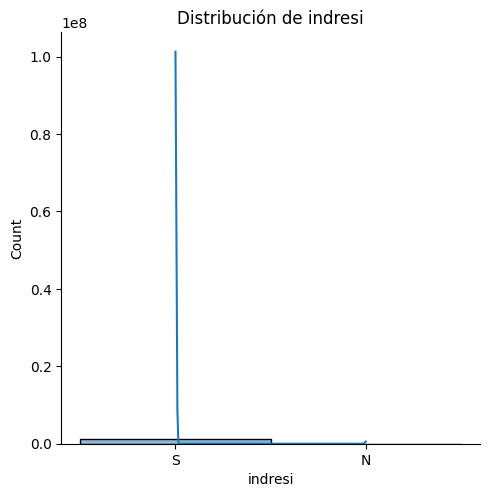

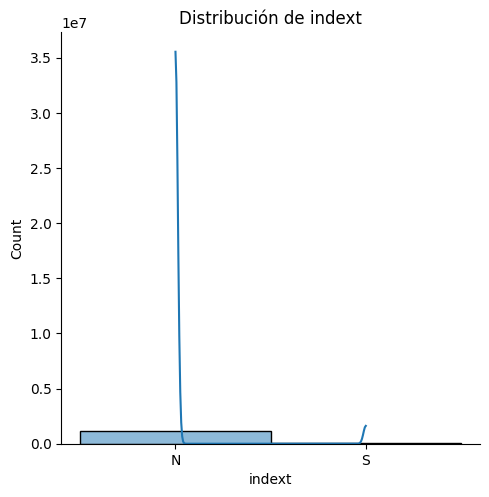

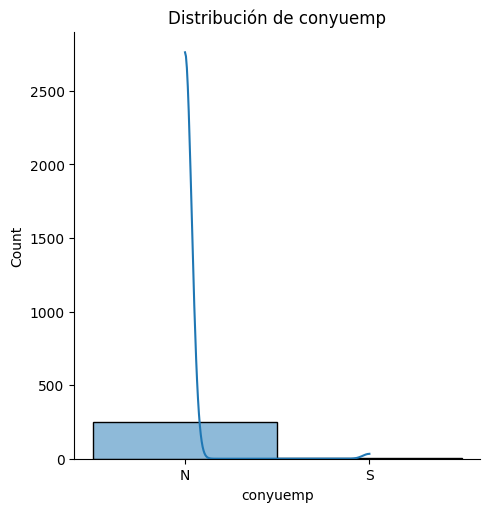

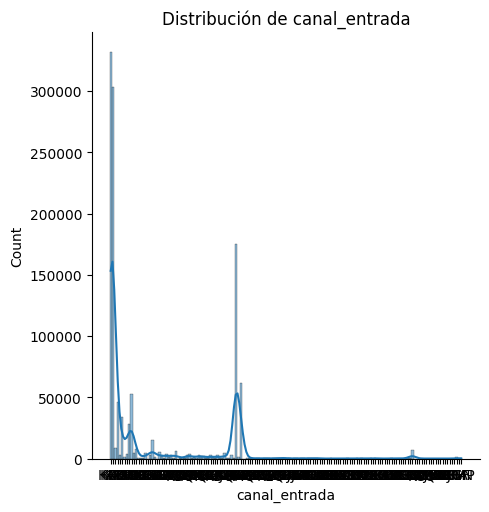

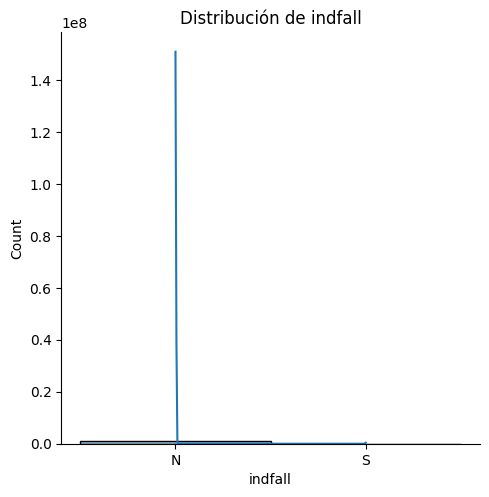

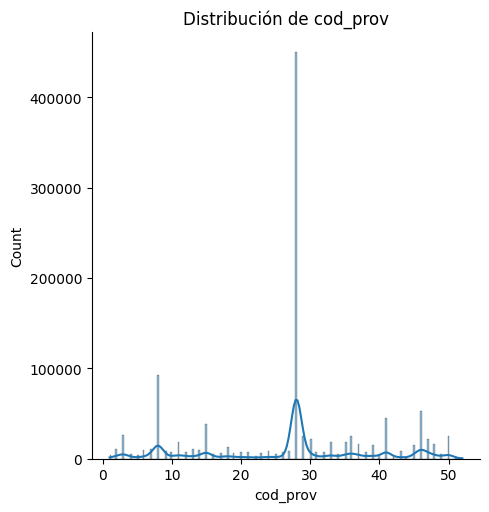

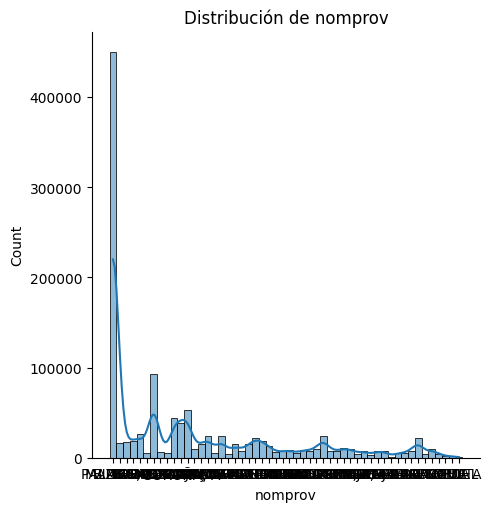

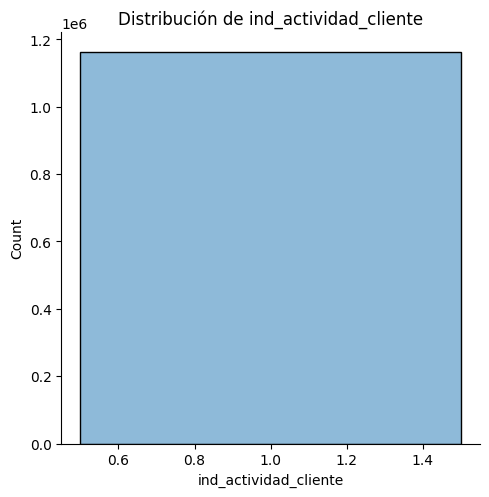

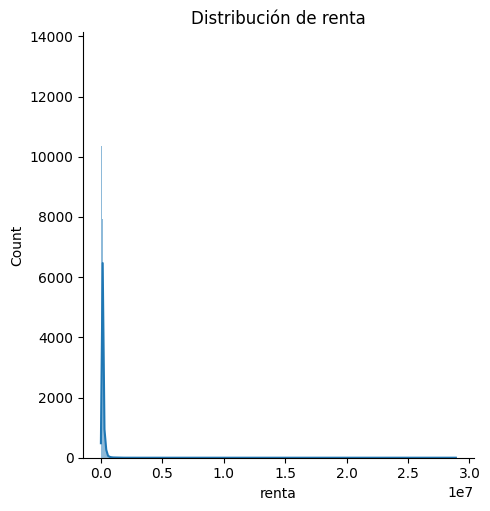

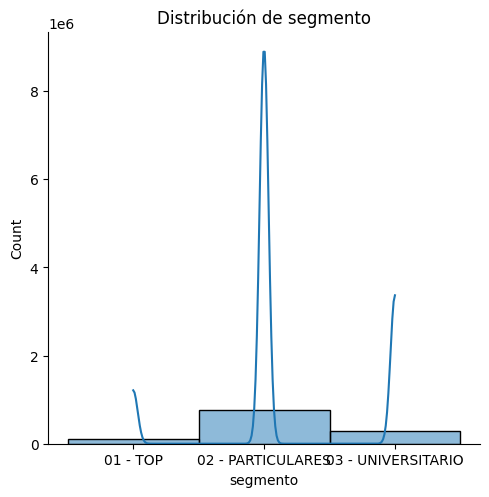

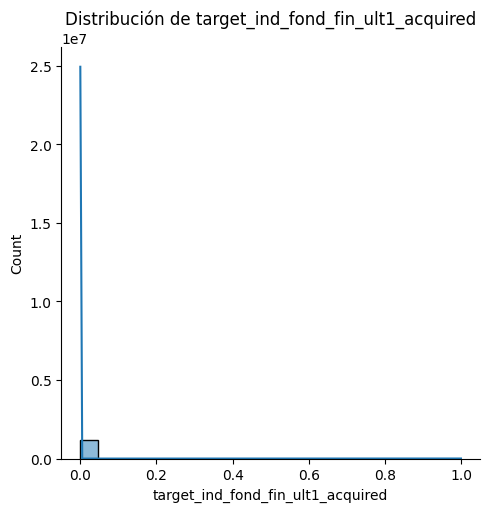

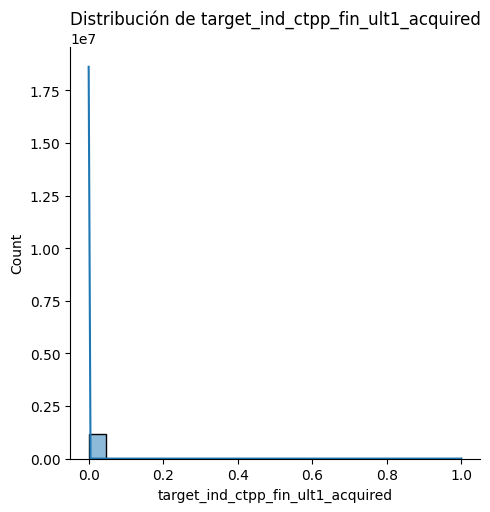

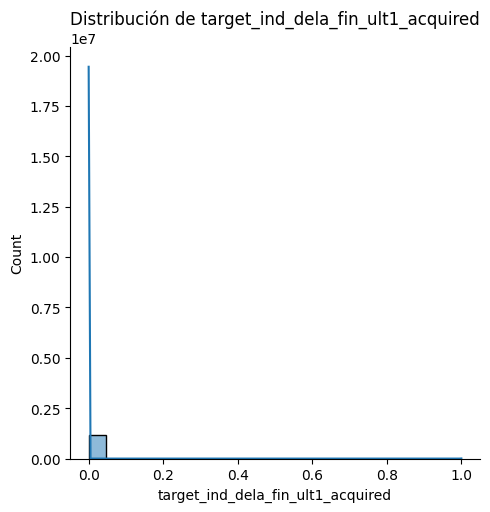

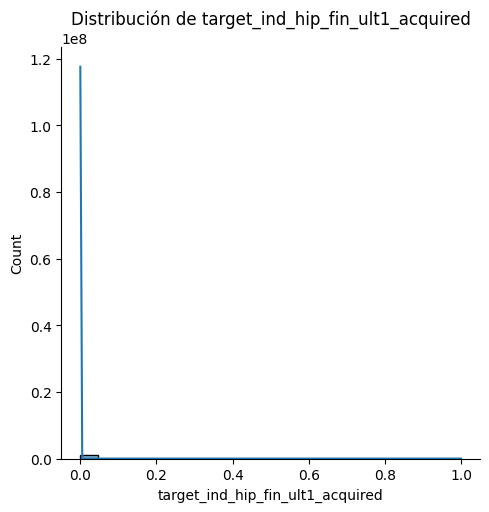

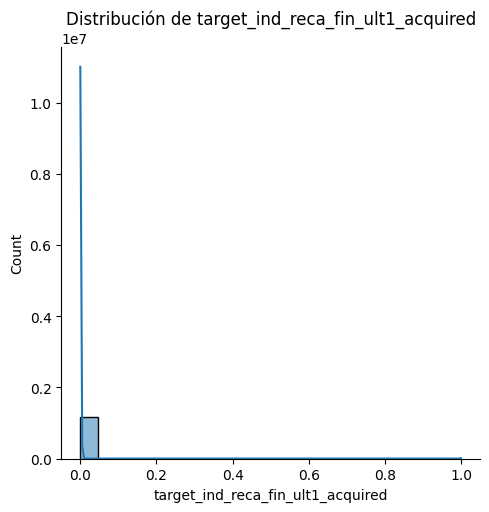

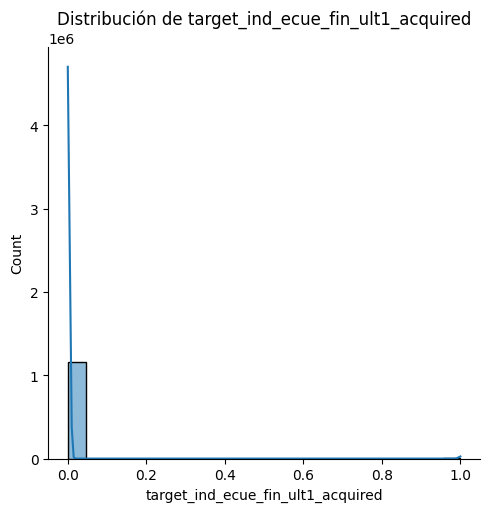

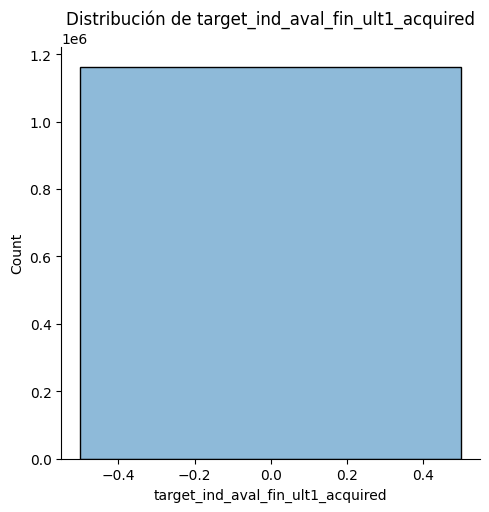

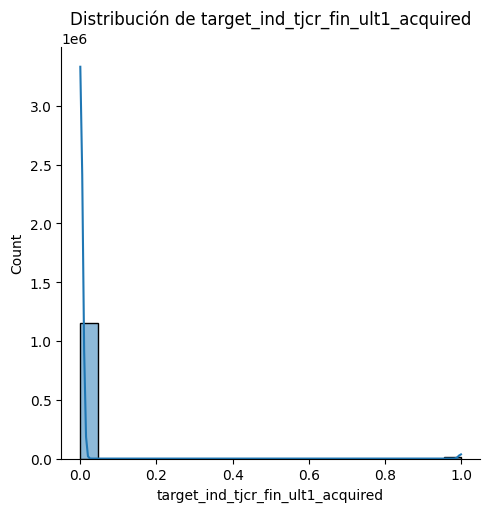

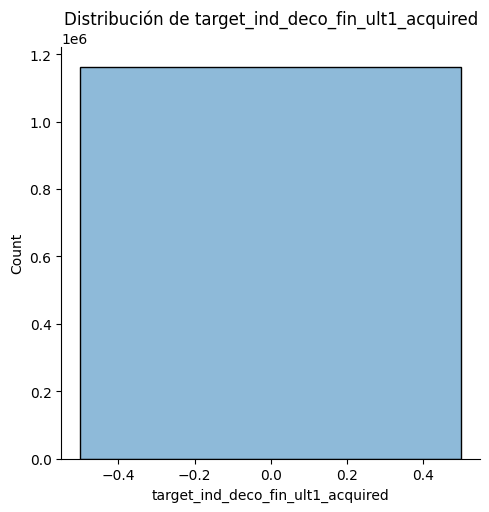

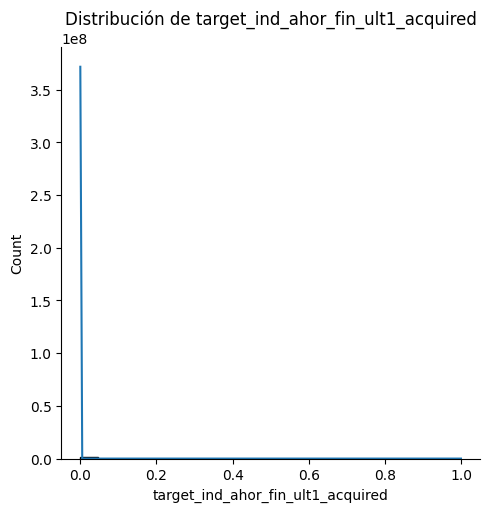

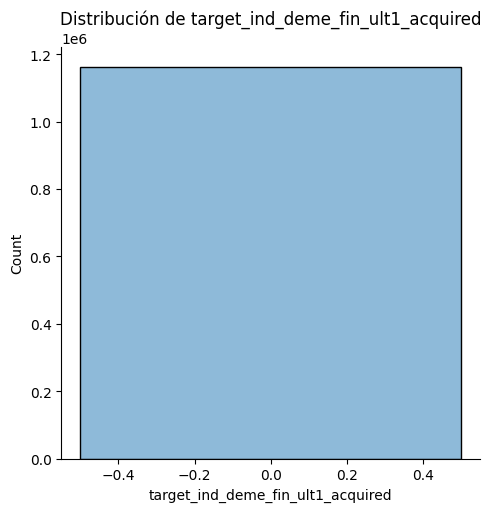

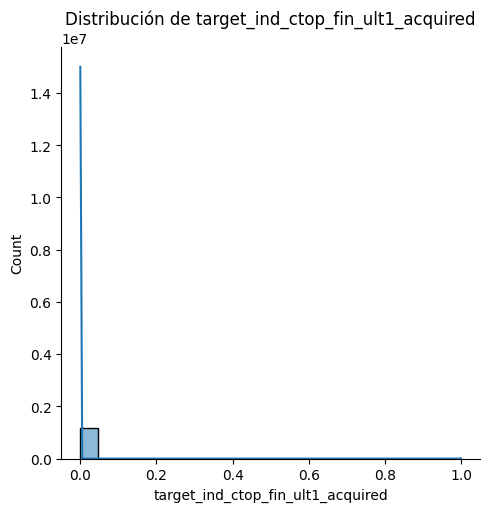

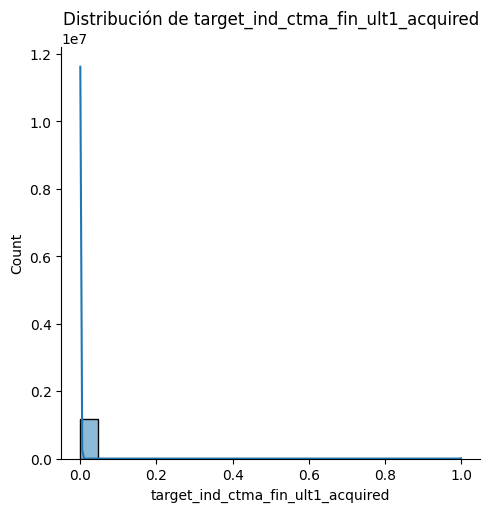

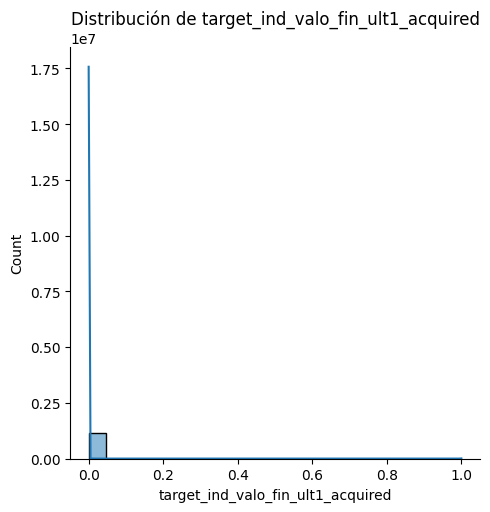

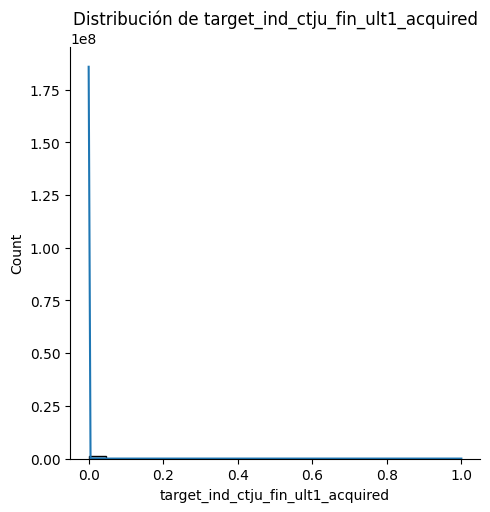

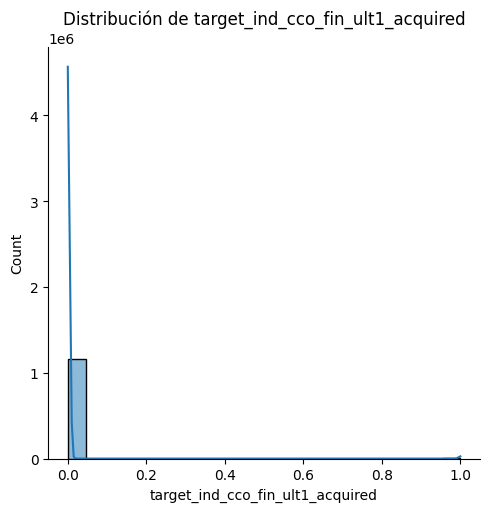

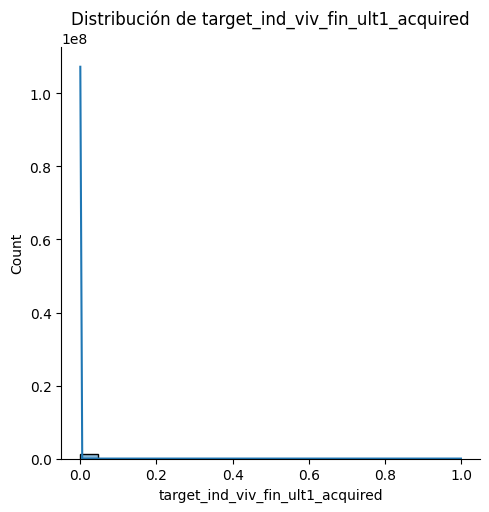

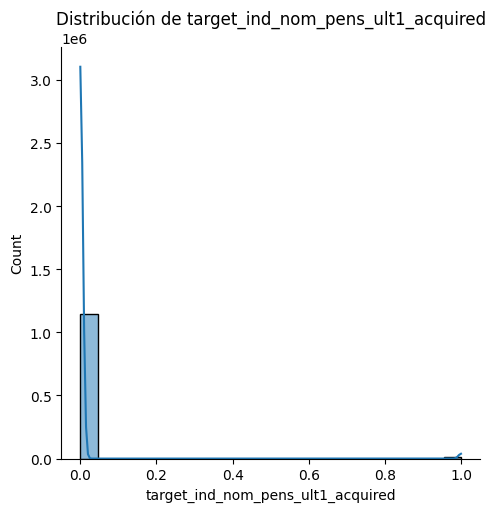

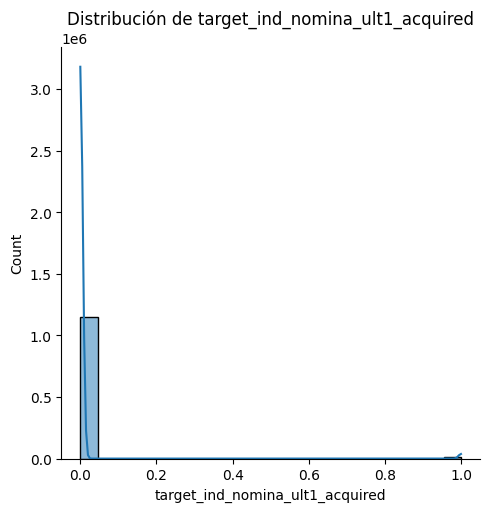

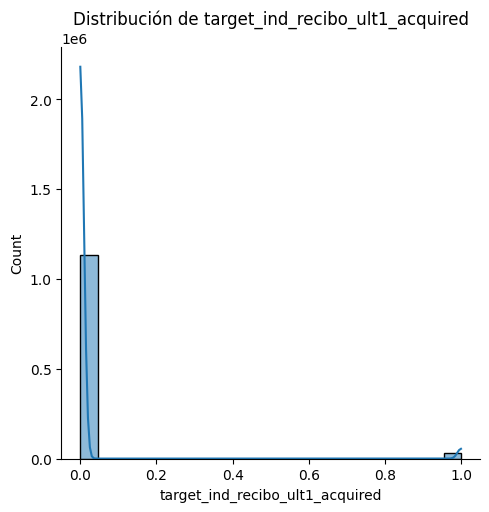

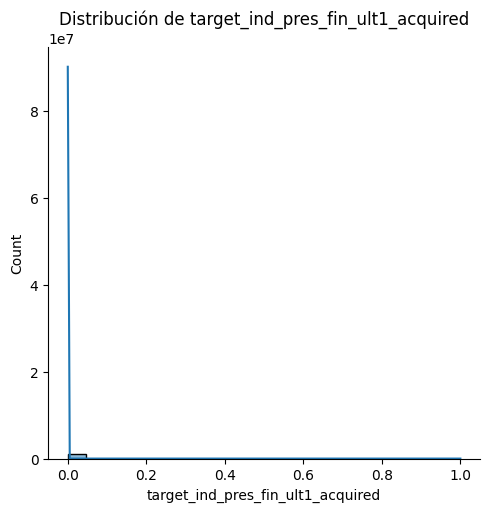

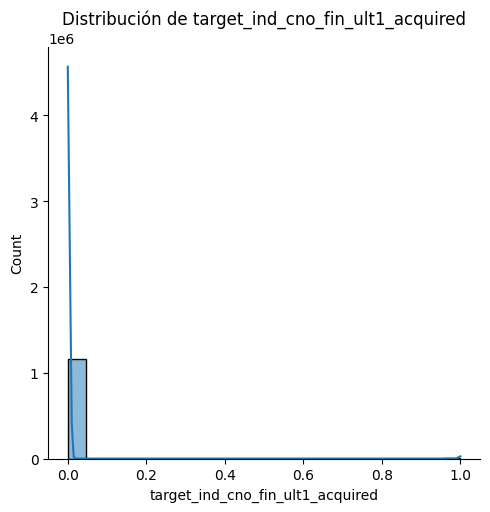

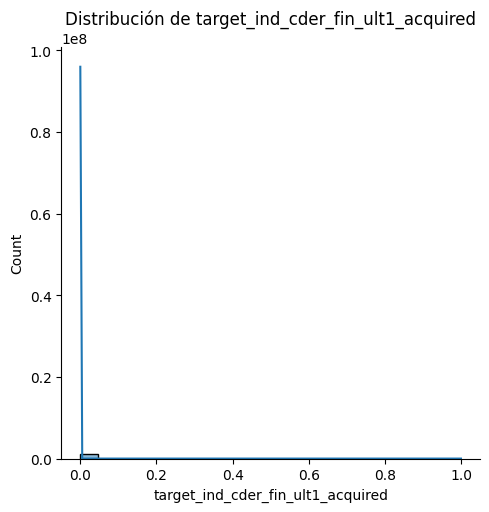

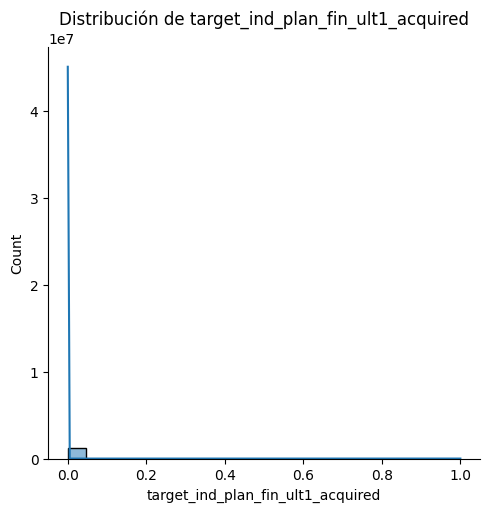

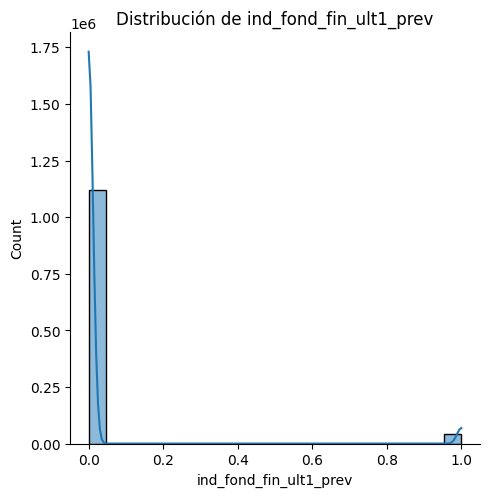

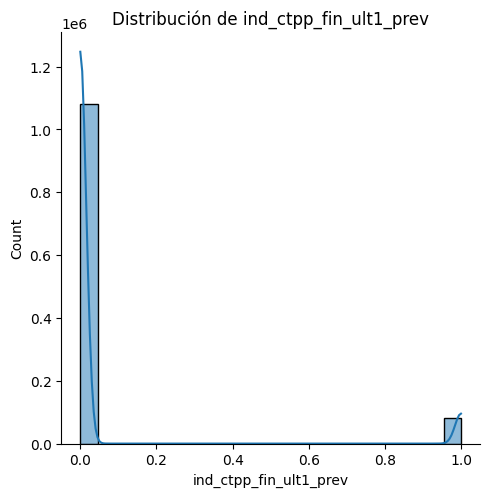

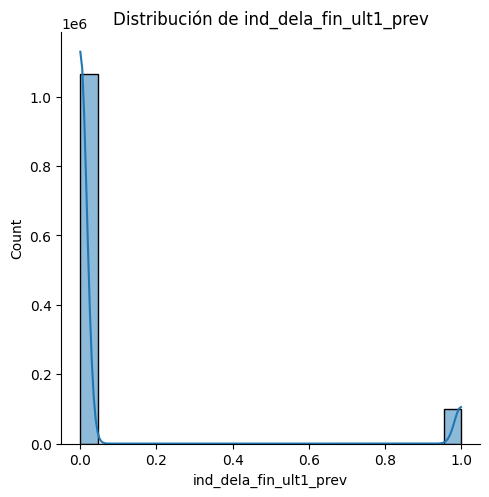

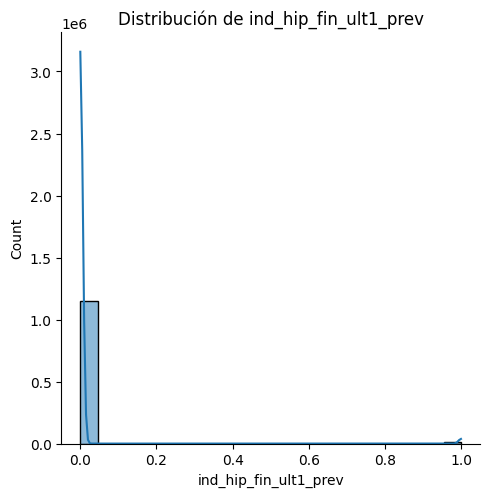

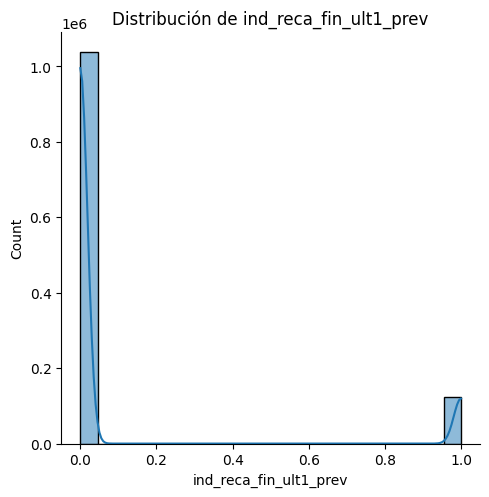

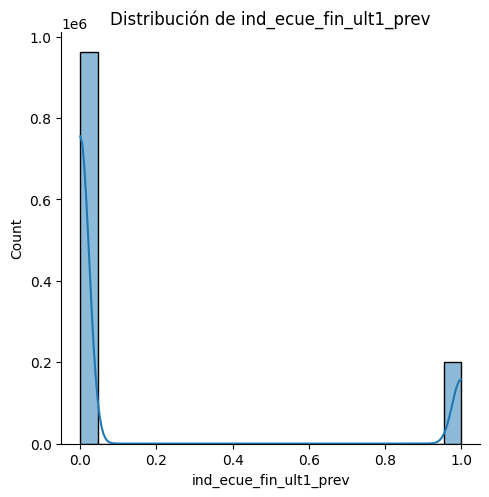

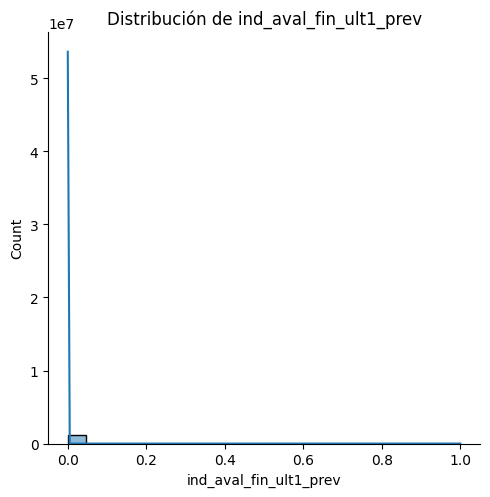

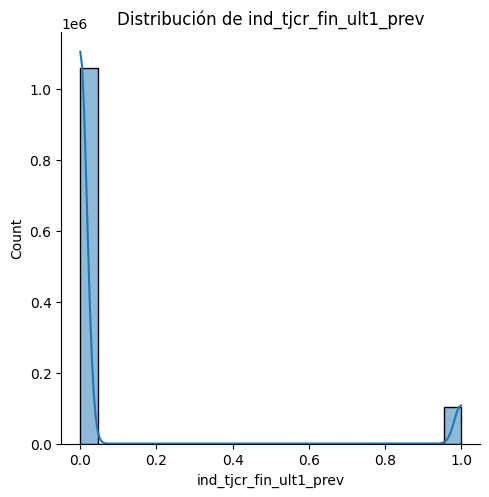

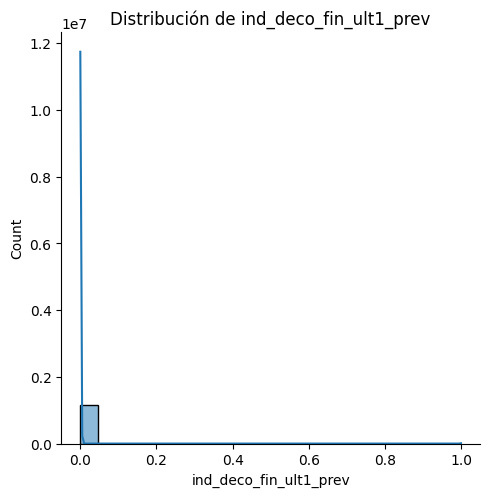

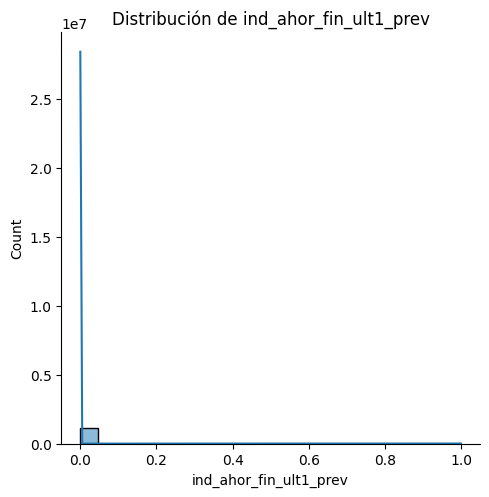

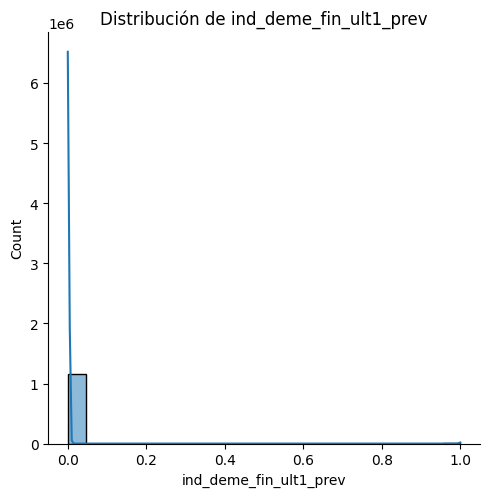

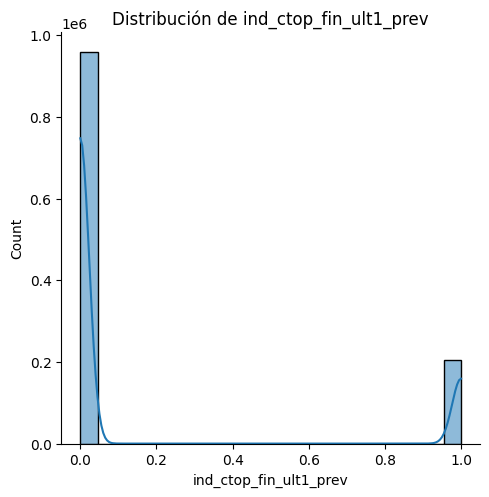

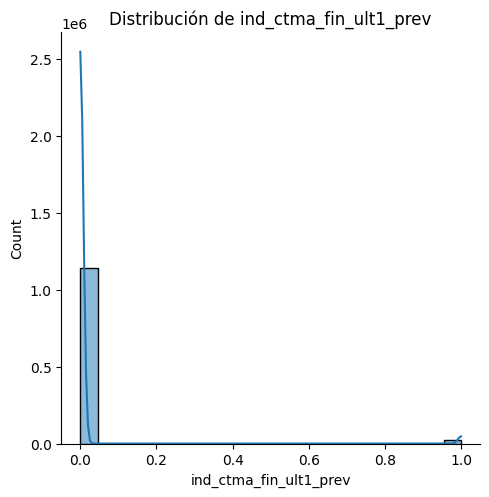

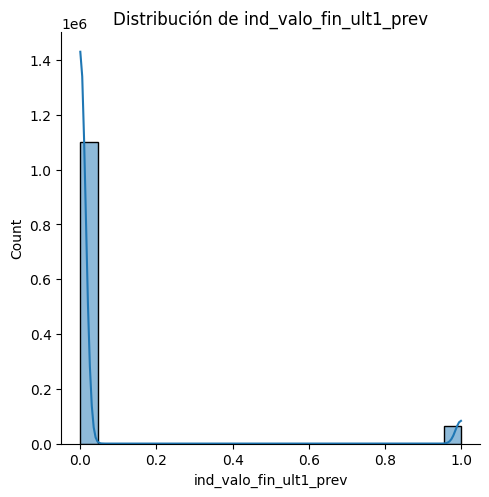

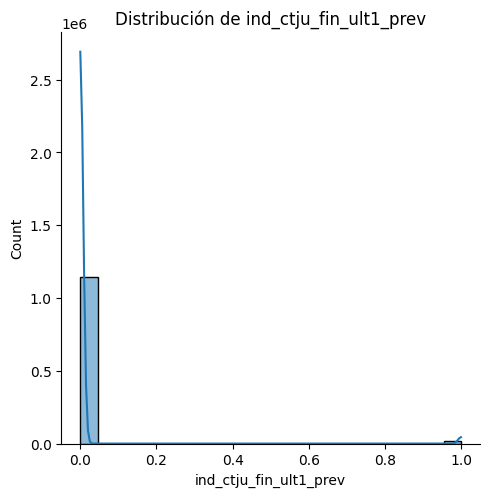

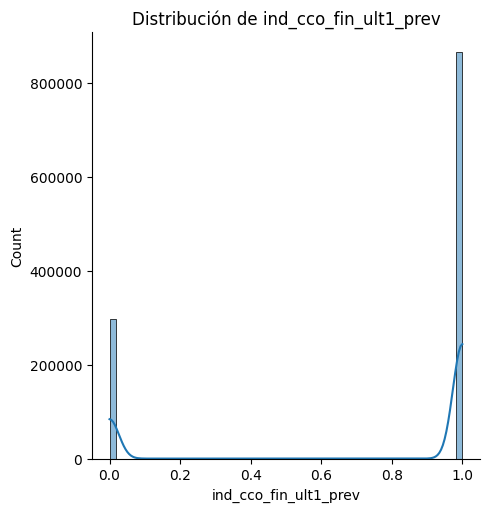

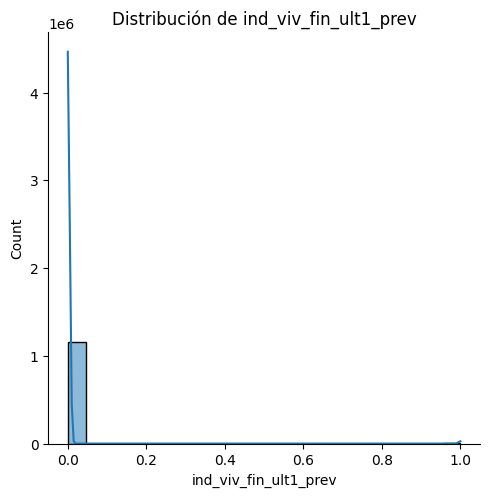

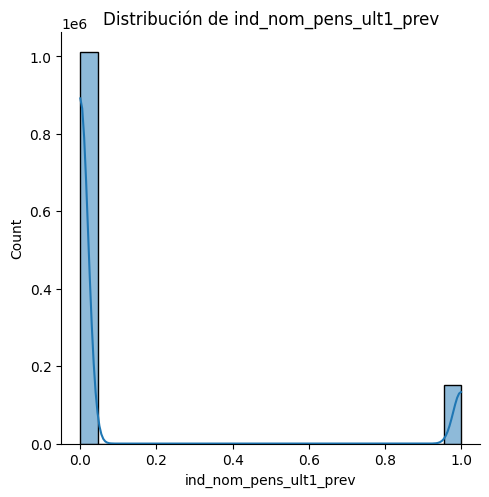

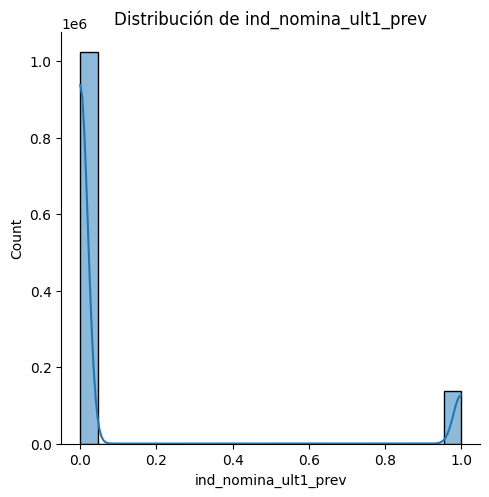

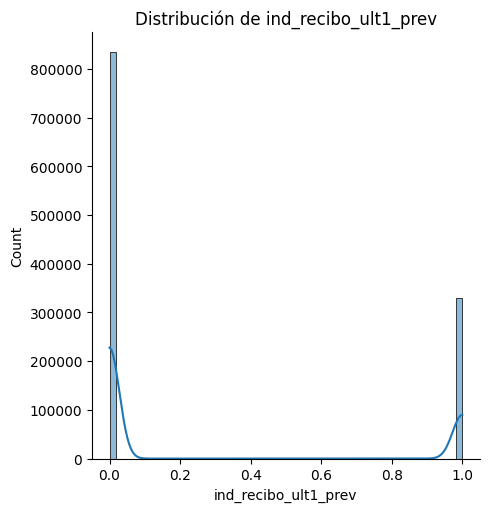

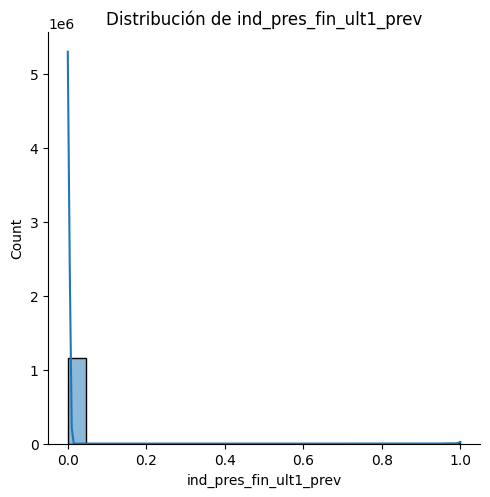

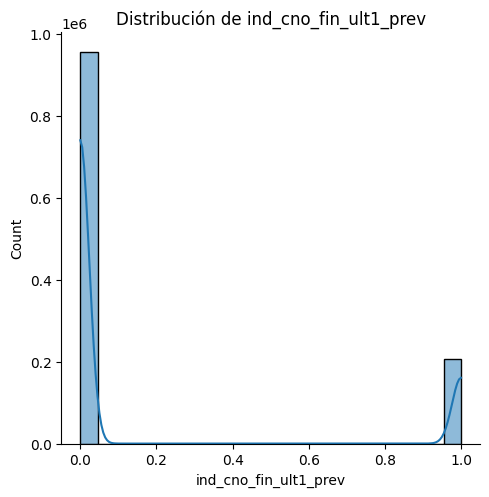

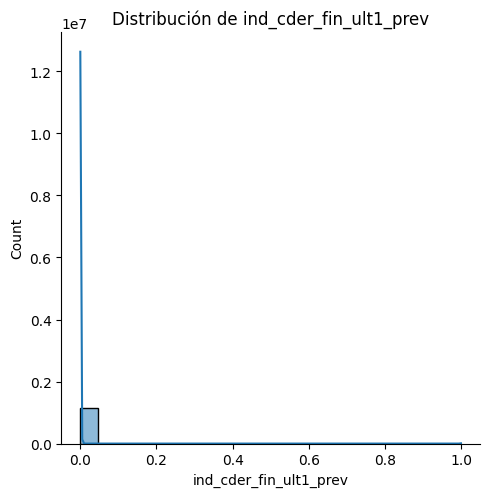

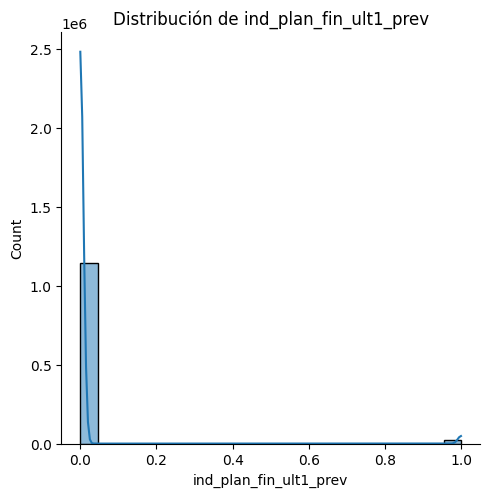

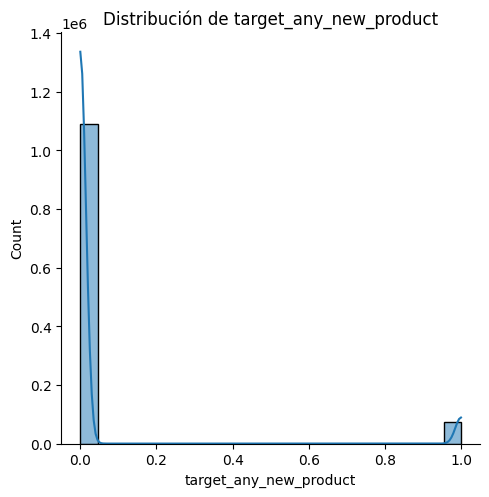

In [ ]:
for column in df.columns:
    sns.displot(df[column], kde=True)
    plt.title(f"Distribución de {column}")
    plt.tight_layout()
    plt.show()